# Physics-Informed Neural Network (PINN) for Solving PDE


The PDE we want to solve is of the form:

$$
U_t - a(x,t)U_{xx} + b(x,t)U_x + c(x,t)U = f(x,t)
$$

with the following boundary conditions:

$$
U(x_L,t) = U_B(x_L,t), \quad U(x_R,t) = U_B(x_R,t), \quad U(x,0) = U_0(x)
$$

where \((x,t) \in [x_L, x_R] \times [0, T]\).

In the example provided:

$$
x_L = 0, \quad x_R = 0.5, \quad T = 0.5
$$

$$
a(x,t) = 1, \quad b(x,t) = 0, \quad c(x,t) = 0
$$

The boundary conditions are:

$$
U_B(0,t) = 0, \quad U_B(0.5,t) = e^{-t}, \quad U_0(x) = \sin(\pi x)
$$

The exact solution is given as:

$$
U(x,t) = \sin(\pi x) \cdot e^{-t}
$$

To determine \( f(x,t) \), we compute:

$$
f(x,t) = U_t - U_{xx} = -\sin(\pi x) \cdot \pi \cdot e^{-t} + \pi^2 \cdot \sin(\pi x) \cdot e^{-t}
$$


## Step 1: Import necessary libraries

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


## Step 3: Create a Neural Network for PINNs
Implement a neural network to solve the PDE using the Physics-Informed Neural Network (PINN) approach.


In [12]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden_layer_2 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden_layer_3 = tf.keras.layers.Dense(20, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, X):
        x = self.hidden_layer_1(X)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)
        output = self.output_layer(x)
        return output


## Step 4: Define the Loss Function
The loss function is defined based on the residual of the PDE, boundary conditions, and initial conditions.


In [13]:
def physics_informed_loss(model, X):
    x, t = X[:, 0:1], X[:, 1:2]
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        U = model(tf.concat([x, t], axis=1))
        U_x = tape.gradient(U, x)
        U_t = tape.gradient(U, t)
        
    U_xx = tape.gradient(U_x, x)
    del tape
    
    # PDE: U_t - U_xx = f(x, t)
    f = U_t - U_xx + np.sin(np.pi * x) * (np.pi * np.exp(-t)) - (np.pi**2) * np.sin(np.pi * x) * np.exp(-t)
    
    return tf.reduce_mean(tf.square(f))


In [14]:
def boundary_condition_loss(model):
    xL = tf.constant([[0.0]], dtype=tf.float32)
    xR = tf.constant([[0.5]], dtype=tf.float32)
    t = tf.random.uniform((100, 1), minval=0.0, maxval=0.5)
    
    U_xL_t = model(tf.concat([xL * tf.ones_like(t), t], axis=1))
    U_xR_t = model(tf.concat([xR * tf.ones_like(t), t], axis=1))
    
    U_L = tf.zeros_like(t)
    U_R = tf.exp(-t)
    
    return tf.reduce_mean(tf.square(U_xL_t - U_L)) + tf.reduce_mean(tf.square(U_xR_t - U_R))


In [15]:
def initial_condition_loss(model):
    x = tf.random.uniform((100, 1), minval=0.0, maxval=0.5)
    t0 = tf.constant([[0.0]], dtype=tf.float32)
    
    U_x_t0 = model(tf.concat([x, t0 * tf.ones_like(x)], axis=1))
    U_0 = tf.sin(np.pi * x)
    
    return tf.reduce_mean(tf.square(U_x_t0 - U_0))


## Step 5: Training the Neural Network
Train the neural network using the defined loss function.

In [16]:
def train_model(model, epochs=10000, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Generate training points
            x = tf.random.uniform((100, 1), minval=0.0, maxval=0.5)
            t = tf.random.uniform((100, 1), minval=0.0, maxval=0.5)
            X = tf.concat([x, t], axis=1)
            
            # Compute the total loss
            loss = (physics_informed_loss(model, X) +
                    boundary_condition_loss(model) +
                    initial_condition_loss(model))
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')


## Step 6: Plotting the Results
We plot the results by comparing the exact solution with the PINN-predicted solution at a specific time step \( t = 0.25 \).


Epoch 0, Loss: 13.642921447753906
Epoch 100, Loss: 0.915964663028717
Epoch 200, Loss: 0.376067578792572
Epoch 300, Loss: 0.25123459100723267
Epoch 400, Loss: 0.1351090371608734
Epoch 500, Loss: 0.06986897438764572
Epoch 600, Loss: 0.045548032969236374
Epoch 700, Loss: 0.02047518640756607
Epoch 800, Loss: 0.018520576879382133
Epoch 900, Loss: 0.018154753372073174
Epoch 1000, Loss: 0.012305222451686859
Epoch 1100, Loss: 0.012175790965557098
Epoch 1200, Loss: 0.013313112780451775
Epoch 1300, Loss: 0.008706191554665565
Epoch 1400, Loss: 0.006533972918987274
Epoch 1500, Loss: 0.006771367974579334
Epoch 1600, Loss: 0.004259854555130005
Epoch 1700, Loss: 0.0045360480435192585
Epoch 1800, Loss: 0.0036924404557794333
Epoch 1900, Loss: 0.0036675031296908855
Epoch 2000, Loss: 0.0033473954536020756
Epoch 2100, Loss: 0.002958514727652073
Epoch 2200, Loss: 0.0030651018023490906
Epoch 2300, Loss: 0.002518242225050926
Epoch 2400, Loss: 0.0025910616386681795
Epoch 2500, Loss: 0.0025829968508332968
Epoc

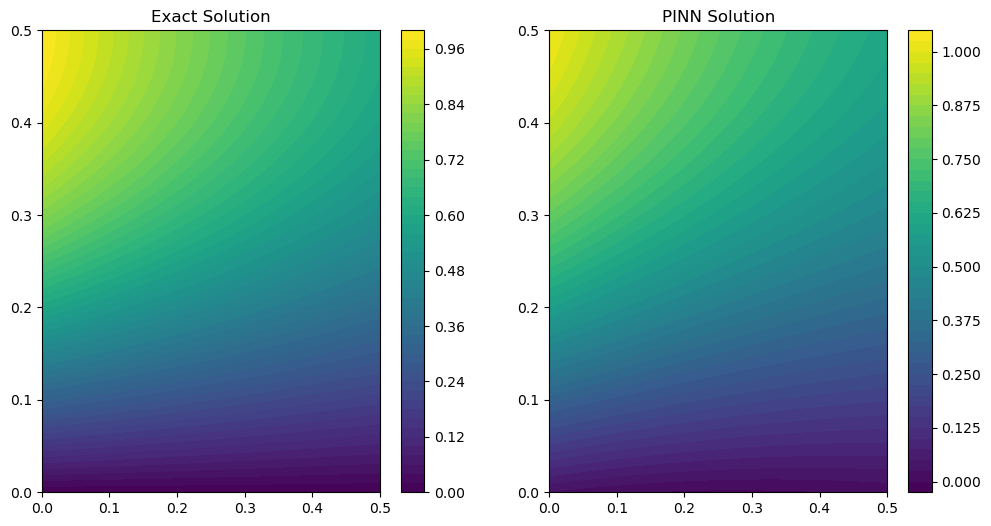

In [17]:
# Define the exact solution
def exact_solution(x, t):
    return np.sin(np.pi * x) * np.exp(-t)

# Train the model
pinn_model = PINN()
train_model(pinn_model, epochs=10000)

# Generate test data
x_test = np.linspace(0, 0.5, 100).reshape(-1, 1)
t_test = np.linspace(0, 0.5, 100).reshape(-1, 1)
X_test = np.array(np.meshgrid(x_test, t_test)).T.reshape(-1, 2)

# Predict the solution
U_pred = pinn_model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy().reshape(100, 100)

# Exact solution
U_exact = exact_solution(X_test[:, 0].reshape(100, 100), X_test[:, 1].reshape(100, 100))

X_test, T_test = np.meshgrid(x_test, t_test)

# Plot results
plt.figure(figsize=(12, 6))

# Exact solution
plt.subplot(1, 2, 1)
plt.contourf(X_test, T_test, U_exact, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Exact Solution')

# PINN solution
plt.subplot(1, 2, 2)
plt.contourf(X_test, T_test, U_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PINN Solution')

plt.show()


### Select a specific time, e.g., t = 0.25:
- **`x_test`**: The spatial points over which the solution is evaluated.
- **`U_exact_t`**: The exact solution values at \( t = 0.25 \).
- **`U_pred_t`**: The PINN-predicted solution values at \( t = 0.25 \).

In [22]:
t_index = np.argmin(np.abs(t_test - 0.25))
U_exact_t = U_exact[:, t_index]
U_pred_t = U_pred[:, t_index]


### Interpretation:
This plot will show two curves, one for the exact solution and one for the PINN solution at the selected time step \( t = 0.25 \). By comparing these two curves, you can visually assess how well the PINN is approximating the exact solution at that particular time.

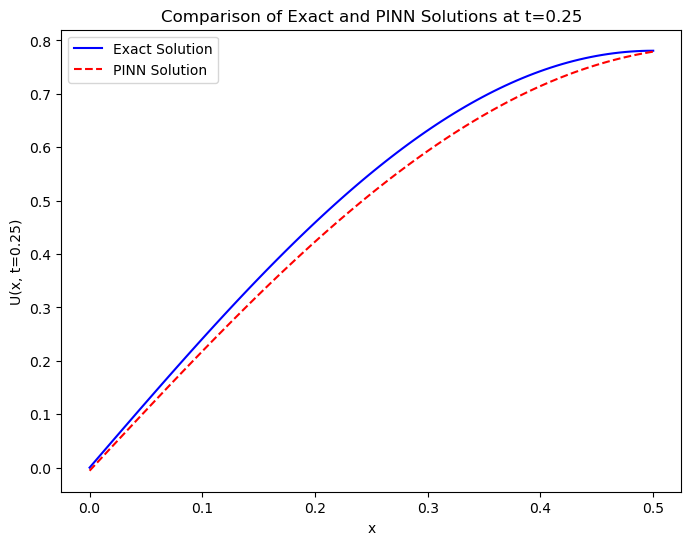

In [23]:
plt.figure(figsize=(8, 6))

plt.plot(x_test, U_exact_t, 'b-', label='Exact Solution')
plt.plot(x_test, U_pred_t, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('U(x, t=0.25)')
plt.title('Comparison of Exact and PINN Solutions at t=0.25')
plt.legend()

plt.show()
